<a href="https://colab.research.google.com/github/kpr-03/DeepLearning_TensorFlow/blob/main/05_Transfer_Learning_with_TensorFlow_Part_2_Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-# Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous notebook,I covered transfer learning feature extraction,now it's time to learn about a new kind of transfer learning:fine-tuning.

In [1]:
# Note: Issues with TensorFlow 2.10+, however, TensorFlow 2.9 seems to work better
# This may be fixed in the future.
# see: https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0
# and here: https://github.com/keras-team/keras/issues/16983

# Install TensorFlow 2.9.0 ("-U" stands for "update", "-q" stands for "quiet")
!pip install -U -q tensorflow==2.9.0

import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 99.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 101.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 62.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.2 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 3.1

In [2]:
!nvidia-smi

Fri Aug 11 13:06:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions
In previous notebooks we created a bunch of helper functions,now we could rewrite themhowever,this is tideous.

So,it's a good idea to put functions you'll want to use again in a script you can download and import itnto your notebook(or eslewhere).

We'v done this for some of th functions we,ve used previously here https://raw.githubusercontent.com/kpr-03/DeepLearning_TensorFlow/main/extras/helper_functions.py

In [3]:
!wget https://raw.githubusercontent.com/kpr-03/DeepLearning_TensorFlow/main/extras/helper_functions.py

--2023-08-11 13:06:08--  https://raw.githubusercontent.com/kpr-03/DeepLearning_TensorFlow/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-11 13:06:08 (95.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
#Import helper functions we're going to use this in this notebook
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir


🔑**Note:**If you're running this notebook In Google colab,when it times out Colab will delete `helper_functions.py`.so,you'll have to re download it if you want to have access to your helper functions.

## Let's get some data.
This time we're going to see how we can use the pretrained models within tf.keras.applications and appply them to mour own problem(recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [5]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-08-11 13:06:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.128, 142.250.145.128, 74.125.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  37.7MB/s    in 4.9s    

2023-08-11 13:06:14 (32.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
unzip_data("10_food_classes_10_percent.zip")

In [7]:
# check out hjow many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [8]:
# create training ansd test directories paths
train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [9]:
import tensorflow as tf
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                           image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                              image_size=IMG_SIZE,
                                                              label_mode="categorical",
                                                              batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [10]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [11]:
# check out the class names of our data set
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [12]:
# see an example of a batch of data
for images,labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[8.33571396e+01 3.63571434e+01 6.35714293e+00]
   [8.17142868e+01 3.47142830e+01 6.71428537e+00]
   [8.06428604e+01 3.36428566e+01 6.07142878e+00]
   ...
   [1.30000000e+01 6.00000000e+00 0.00000000e+00]
   [1.29744854e+01 5.97448492e+00 0.00000000e+00]
   [1.24132433e+01 5.41324282e+00 0.00000000e+00]]

  [[8.63316269e+01 3.60000000e+01 9.00000000e+00]
   [8.69285736e+01 3.68622437e+01 9.86224556e+00]
   [8.46836700e+01 3.47295914e+01 8.14285755e+00]
   ...
   [1.40000000e+01 7.00000000e+00 0.00000000e+00]
   [1.39285717e+01 6.92857170e+00 0.00000000e+00]
   [1.30000000e+01 6.00000000e+00 0.00000000e+00]]

  [[9.28622437e+01 3.77193871e+01 1.22908163e+01]
   [9.10867310e+01 3.70561218e+01 1.10714283e+01]
   [8.78316345e+01 3.66173439e+01 1.02602043e+01]
   ...
   [1.52142859e+01 8.21428585e+00 2.14285851e-01]
   [1.50000000e+01 8.00000000e+00 0.00000000e+00]
   [1.42142859e+01 7.21428585e+00 0.00000000e+00]]

  ...

  [[1.30846817e+02 1.03632561e+02 9.26325607e+01]
   [1

## Model 0: Building a transfer learning feature extraction  model using the Keras Functional API
The sequential API is straight forward,it runs our layer in sequential order.
But the functional API gives ur more flexibility with our models - https://www.tensorflow.org/guide/keras/functional_api

In [13]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model( so the underlying pre-trained patterns aren't updated during training)

base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")


# 4. If using ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model:{x.shape}")

# 6. Average pool the outputs of the base model(aggregate all the mosdt importatnt information,reduce number of computations)
x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

print(f"Shape after GlobalAveragePooling2D:{x.shape}")

# 7. create the output activation layer
outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

# 8. cobine the inputs with the outputs into a model

model_0 = tf.keras.Model(inputs,outputs)


# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs =5,
                                 steps_per_epoch =len(train_data_10_percent),
                                 validation_data= test_data,
                                 validation_steps= int(0.25*len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])


16705208/16705208 [==============================] - 1s 0us/step
Shape after passing inputs through base model:(None, 7, 7, 1280)
Shape after GlobalAveragePooling2D:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230811-130623
Epoch 1/5
24/24 [==============================] - 30s 274ms/step - loss: 1.8643 - accuracy: 0.4333 - val_loss: 1.2712 - val_accuracy: 0.7467
Epoch 2/5
24/24 [==============================] - 4s 153ms/step - loss: 1.0729 - accuracy: 0.7853 - val_loss: 0.8591 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - 5s 183ms/step - loss: 0.7780 - accuracy: 0.8267 - val_loss: 0.6808 - val_accuracy: 0.8569
Epoch 4/5
24/24 [==============================] - 5s 192ms/step - loss: 0.6356 - accuracy: 0.8533 - val_loss: 0.5789 - val_accuracy: 0.8684
Epoch 5/5
24/24 [==============================] - 4s 148ms/step - loss: 0.5318 - accuracy: 0.8827 - val_loss: 0.5451 - val_accuracy: 0.8717


In [14]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 9s 98ms/step - loss: 0.5527 - accuracy: 0.8628


[0.5527364015579224, 0.8628000020980835]

In [15]:
# check the layers in our ase model
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [16]:
# how abou we get summary of base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [17]:
# nhow about a summary of our who;le model?
model_0.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


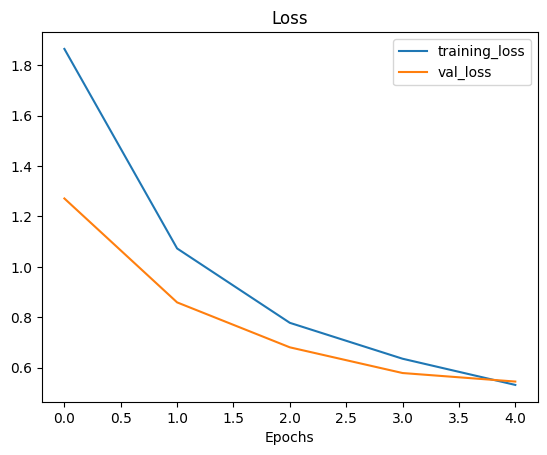

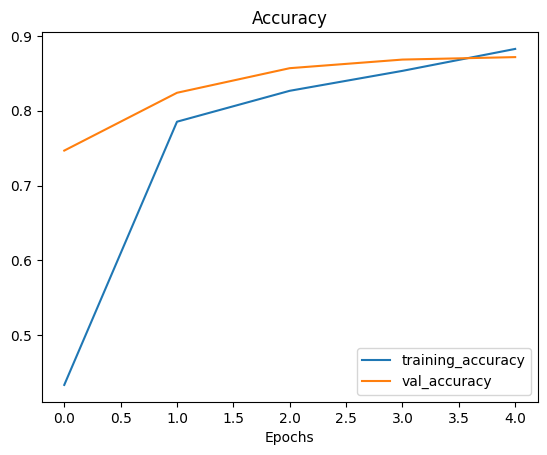

In [18]:
# check out our model's training params
plot_loss_curves(history_10_percent)

## getting a feature vector from a trained model
Let's demonstrate tThe Global average Pooling 2D layer...
We have a tensor after our model goes through `base_model` of shape (None,7,7,1280).

But then when it passes through GlobalAveragepooling2D,it turns into(None,1280).

Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D.

In [19]:
# Define the input shape
input_shape=(1,4,4,3)

# create a random tensor
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tenso through a global averge Pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D Global average pooled random tensor:\n{global_average_pooled_tensor}\n")

# check the shape of different tensors
print(f"Shape of input tensor:{input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor:{global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D Global average pooled random tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor:(1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor:(1, 3)


In [20]:
# Let's replicate the GlovalAveragePool2D layer
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

⚒**Practice:** try to do the same with the above two cells but this time use `GlobalMaxPool2D`...and see what happens.

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can geet with only 10% of the training data,but how does it go with 1% of the training data...how about we set up a bunch oif experiments to find out:

1. `model_1`- use feature extraction transfer learning with 1% of the training data with data augmentation.
2. `model_2` use feature extraction transfer learning with 10% of the training data with data augmentation.
3.`model_3`: Use fine-tuning transfer learning on 10% of the training data with data augmentation.
4.`model_4`: Use fine-tuning transfer learning on 100% of the training data with data augmentation.

🔑**Note:** throughout all experiments the same test dataset will be used to evaluate our model..this ensures consistent evaluation metrics.

## Getting and preprocessing data for model_1

In [21]:
# download and unzip data- preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2023-08-11 13:07:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 172.217.218.128, 142.251.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  35.0MB/s    in 3.8s    

2023-08-11 13:07:33 (33.1 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [22]:
unzip_data("10_food_classes_1_percent.zip")

In [23]:
# create training and test dirs
train_dir_1_percent ="10_food_classes_1_percent/train"
test_dir ="10_food_classes_1_percent/test"

In [24]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There a

In [25]:
# set up data loaders
IMG_SIZE=(224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) # DEFAULT=32
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                      label_mode="categorical",
                                                                      image_size=IMG_SIZE,
                                                                      batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into model
To add data augmentation right into our models,we can use the layers inside:
* `tf.keras.layers.experimental.preprocessing()`

We can see benfits of this within the TensorFlow Data augmentation documnetation: https://www.tensorflow.org/tutorials/images/data_augmentation


Off the top of our hrads,after reading docs,the benefits of using data augmentation inside the model are:
* preprocessing of images(augmenting them) happens on the GPU(much faster) rather than the CPU.
* Image data augmentation only happens during training,so we can still export our whole model and use it elsewhere.

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# create data augmentation stage wih horizontal flipping,rotationss,zooms,etc
data_augmentation= keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # keep for models like ResNet50V2 but EfficientNet's have rescaling built-in.
],name="data_augmentation")

### Visualize our data augmentation layer(and see what happens to our data)

(-0.5, 570.5, 340.5, -0.5)

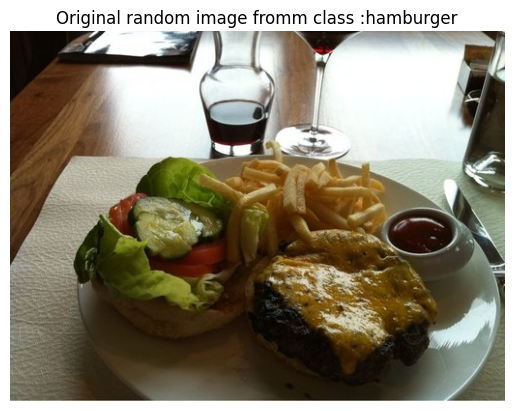

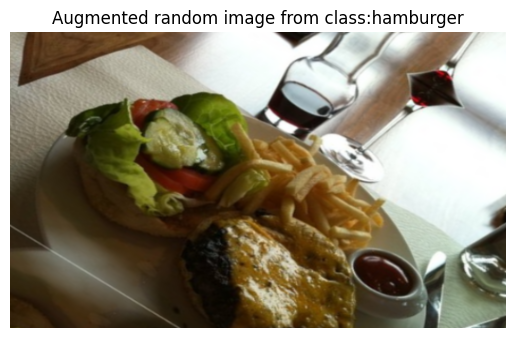

In [27]:
# view a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img= mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image fromm class :{target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(img,training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class:{target_class}")
plt.axis(False)
#print(augmented_img)

# Model 1: Feature extraction transfer learning with 1% data with data augmentation.

In [28]:
# setup input image and base model,freezing the base model layers
input_shape =(224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape,name="input_layer")

# Add in data augmentation Sequential model as layer
x = data_augmentation(inputs)

# Give bas_model the inputs (after augmentation) and don't train it
x = base_model(x,training=False)

# Pool output features of the base model
x=layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10,activation="softmax",name="output_layer")(x)

# make a model using the inputs and outputs
model_1 = keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])



Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230811-130739
Epoch 1/5


3/3 [==============================] - ETA: 0s - loss: 2.4065 - accuracy: 0.1714

3/3 [==============================] - 13s 4s/step - loss: 2.4065 - accuracy: 0.1714 - val_loss: 2.2326 - val_accuracy: 0.1760
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1330 - accuracy: 0.3000 - val_loss: 2.0968 - val_accuracy: 0.2714
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9237 - accuracy: 0.4286 - val_loss: 1.9811 - val_accuracy: 0.3355
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7719 - accuracy: 0.5857 - val_loss: 1.8725 - val_accuracy: 0.4030
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6125 - accuracy: 0.6857 - val_loss: 1.7751 - val_accuracy: 0.4589


In [29]:
# check out the model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [30]:
# 3valuate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 8s 89ms/step - loss: 1.7757 - accuracy: 0.4632


[1.775695562362671, 0.46320000290870667]

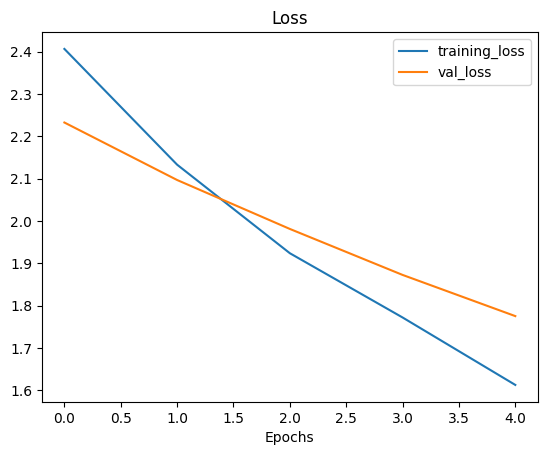

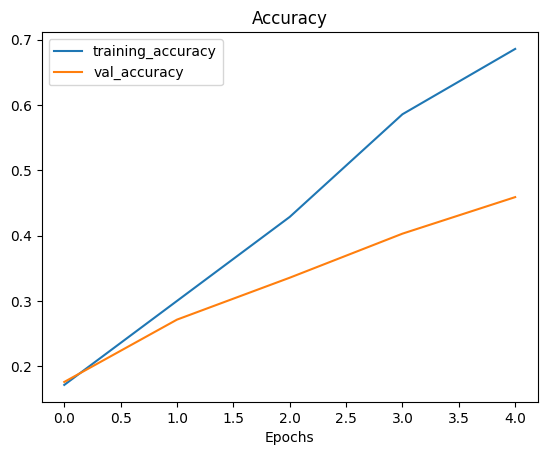

In [31]:
# how do the model with 1% of the and data augmentation loss curve looks?
plot_loss_curves(history_1_percent)

# Model 2: Feature extraction transfer learning model with 10% of data and data augmentation

In [32]:
# Get 10% of data...
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
#unzip_data("10_food_classes_10_percent")


In [33]:
train_dir_10_percent ="10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [34]:
# Set data inputs
import tensorflow as tf
IMG_SIZE =(224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_10_percent,
    label_mode="categorical",
    image_size=IMG_SIZE
)
test_data =tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [35]:
# create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.rescaling(1./255) # if you're using a model such as ResNet50V2,you'll need to rescale your data,efficientnet has rescaling built-in
],name="data_augmentation")

# setup the input shape to our model
input_shape = (224,224,3)

# create a frozen base model(also called the backbone)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs(including the layers in between)
inputs = layers.Input(shape=input_shape,name="input_layer")
x= data_augmentation(inputs) # augment our training images(augmentation doesn't occur on test data)
x= base_model(x,training=False) # pass augmented images to base model but keep it in inference mode,this also insures batchnorm layers don't get updated -https://keras.io/guides/transfer_learning/#build-a-model
x= layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs= layers.Dense(10,activation="softmax",name="output_layer")(x)
model_2=tf.keras.Model(inputs,outputs)

# compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])





### Creating a model checkpoint callback

The ModelCheckpoint callback intermediately saves our model(the full model or just the weights)during training.This is useful so we can come and start where we left off.

In [36]:
# set checkpoint path
checkpoint_path ="ten_percent_model_checkpoints_weights/checkpoint.ckpt"

#Create a ModelCheckpoint callbaqck that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                               save_weights_only = True,
                                               save_best_only=False,
                                               save_freq="epoch",# save every epoch
                                               verbose=1)

### fit model 2 passing in the ModelCheckpoint callback


In [37]:
# Fit the model saving checkpoints every epoch
initial_epochs =5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,validation_steps=int(0.25*len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])


Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230811-130826
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9615 - accuracy: 0.3813
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 20s 565ms/step - loss: 1.9615 - accuracy: 0.3813 - val_loss: 1.4118 - val_accuracy: 0.7007
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2914 - accuracy: 0.6813
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 15s 586ms/step - loss: 1.2914 - accuracy: 0.6813 - val_loss: 0.9796 - val_accuracy: 0.8043
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9812 - accuracy: 0.7733
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 519ms/step - loss: 0.9812 - accuracy: 0.7733 - val_loss: 0.7940 - val_accuracy: 0.8174
E

In [38]:
#W hat were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 6s 69ms/step - loss: 0.5527 - accuracy: 0.8628


[0.5527365803718567, 0.8628000020980835]

In [39]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 9s 102ms/step - loss: 0.6225 - accuracy: 0.8404


[0.6224950551986694, 0.840399980545044]

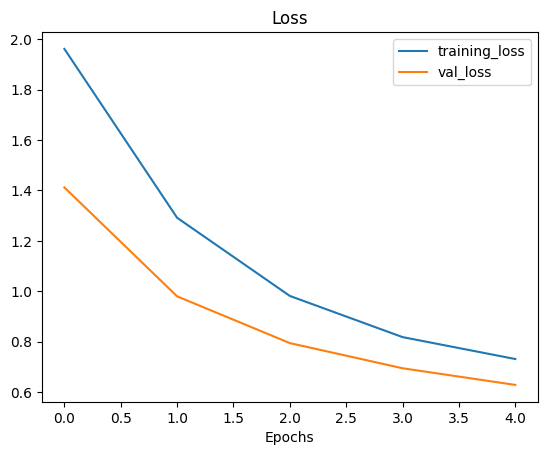

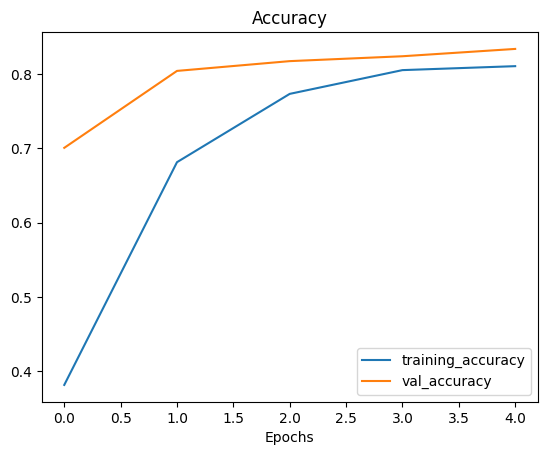

In [40]:
# plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights
Loading in checkpointed weights returns a model to a specific checkpoint.


In [41]:
# load in saved model weights and evaluate model.
model_2.load_weights(checkpoint_path)

In [42]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.6225 - accuracy: 0.8404


In [43]:
# If the results from our previously evbaluated model_2 match the loaded weights,everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

False

In [44]:
results_10_percent_data_aug

[0.6224950551986694, 0.840399980545044]

In [45]:
loaded_weights_model_results

[0.6224949955940247, 0.840399980545044]

In [46]:
# check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug),np.array(loaded_weights_model_results))

array([ True,  True])

In [47]:
# check the difference  between the two results
print(np.array(results_10_percent_data_aug)-np.array(loaded_weights_model_results))

[5.96046448e-08 0.00000000e+00]


### Model 3: Fine - tuning an existing model on 10% of data

> 🔑**Note:**Fine-tuning usually works best after training a feature extraction for a few epochs with large amount of custom data.

In [48]:
# Layers in loaded model
model_2.layers

In [49]:
# Are these layers trainable
for layer in model_2.layers:
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7e37af7fbf40> True
<keras.engine.sequential.Sequential object at 0x7e37af76fdf0> True
<keras.engine.functional.Functional object at 0x7e37c607d960> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7e37af7fbf10> True
<keras.layers.core.dense.Dense object at 0x7e37af76f580> True


In [50]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [51]:
# How many trainabale variables in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [52]:
# To begin fien-tuning ,let;'s start by setting the last 10 layers of our base_model.
base_model.trainable = True

# freeze all layers except for thr last 10

for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile(we have ot recompile our models every time we make a change)

model_2.compile(loss="categorical_crossentropy",
                optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001),# when fine-tuning you typically want to lower learning rate by 10x
                metrics=["accuracy"])

🔑**Note:**When using fine-tuning it's best practice to lower your learning rate by some amount.How much?This is a hyperparameter you can tune.But a good rule of thumb is atleast 10x(though different sources will claim other values).

A good resource for information on this is ULMFiT paper: https://arxiv.org/abs/1801.06146

In [53]:
#check which layers are tunable(trainable)
for layer_number,layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [54]:
# Now we've unfrozen some of the layers closer to the top,how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [55]:
# model_2.trainable_variables

In [56]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model(same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230811-131031
Epoch 5/10
24/24 [==============================] - 20s 506ms/step - loss: 0.6016 - accuracy: 0.8467 - val_loss: 0.5062 - val_accuracy: 0.8421
Epoch 6/10
24/24 [==============================] - 11s 418ms/step - loss: 0.4842 - accuracy: 0.8653 - val_loss: 0.4768 - val_accuracy: 0.8454
Epoch 7/10
24/24 [==============================] - 10s 411ms/step - loss: 0.4222 - accuracy: 0.8800 - val_loss: 0.4564 - val_accuracy: 0.8520
Epoch 8/10
24/24 [==============================] - 9s 366ms/step - loss: 0.3623 - accuracy: 0.9027 - val_loss: 0.4423 - val_accuracy: 0.8470
Epoch 9/10
24/24 [==============================] - 9s 339ms/step - loss: 0.3299 - accuracy: 0.9000 - val_loss: 0.4233 - val_accuracy: 0.8503
Epoch 10/10
24/24 [==============================] - 9s 367ms/step - loss: 0.3028 - accuracy: 0.9187 - val_loss: 0.4538 - val_accuracy: 0.8503


In [57]:
# Evaluate the fine-tuned model(model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.4293 - accuracy: 0.8576


In [58]:
results_10_percent_data_aug

[0.6224950551986694, 0.840399980545044]

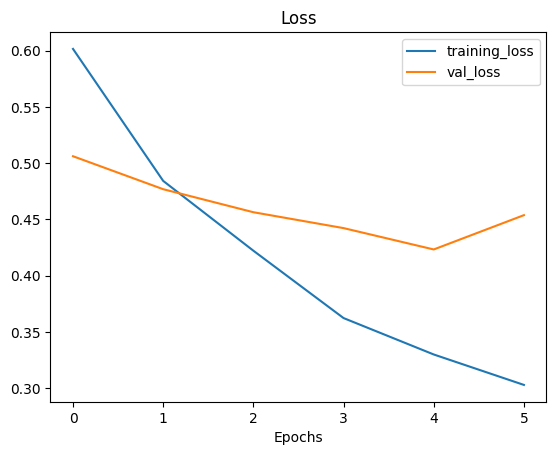

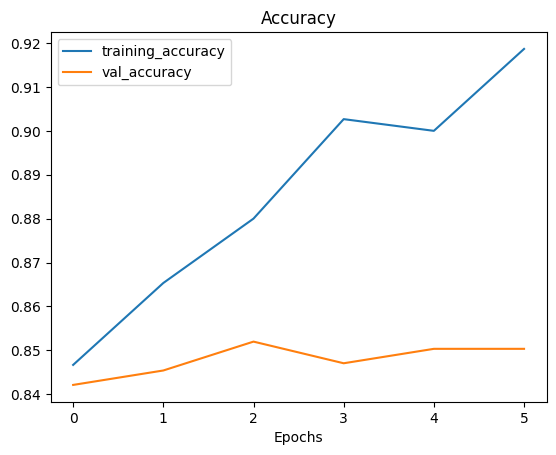

In [59]:
# check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curve` function works gret with n models which have only been fit once,we want something bto ncompare one series of running `fit()` with another(e.g. before and after fine tuning)

In [60]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plot for accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')


    # Make plot for loss

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


5
11
[0.3813333213329315, 0.6813333630561829, 0.7733333110809326, 0.8053333163261414, 0.8106666803359985, 0.846666693687439, 0.8653333187103271, 0.8799999952316284, 0.9026666879653931, 0.8999999761581421, 0.918666660785675]


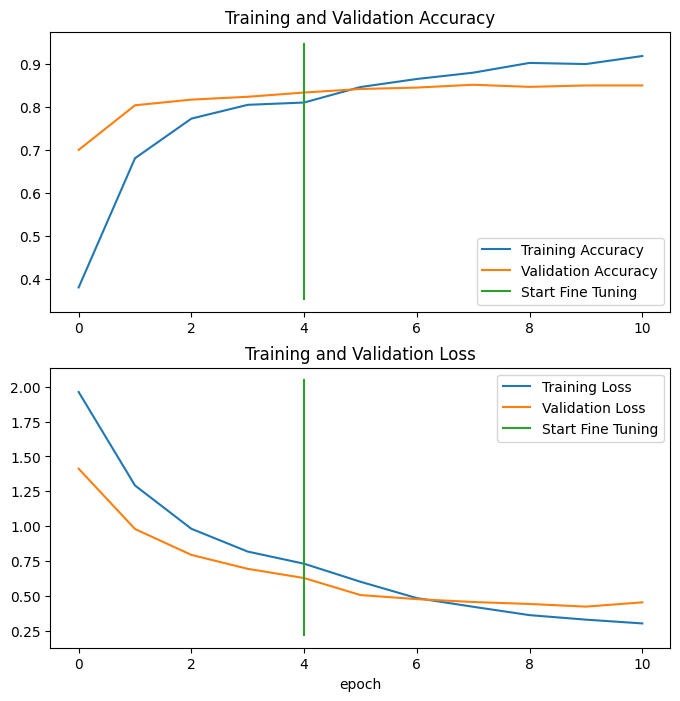

In [61]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)

### Model 4: Fine-tuning and existing model on all of the data

In [62]:
# Download and unzip 10 classes of food 101 data with all images.
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2023-08-11 13:11:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.31.128, 142.251.18.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  39.8MB/s    in 14s     

2023-08-11 13:12:11 (36.3 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [63]:
# setup training and test dirs
train_dir="10_food_classes_all_data/train"
test_dir="10_food_classes_all_data/test"

In [64]:
# how many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.

In [65]:
#  setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                    image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The **test dataset is the same** we've been using for our previous experiments.

As it is now, our `model_2` has been fine-tuned on 10 percent of the data, so to begin fine-tuning on all of the data and keep our experiments consistent, we need to revert it back to the weights we checkpointed after 5 epochs of feature-extraction.

To demonstrate this, we'll first evaluate the current `model_2`.

In [66]:
# Evalauet model_2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.4293 - accuracy: 0.8576


[0.4293264150619507, 0.8575999736785889]

In [67]:
results_fine_tune_10_percent

[0.4293265640735626, 0.8575999736785889]

To train a fine-tuning model(model_4)we need to revert model_2 back to its feature extraction weights.

In [68]:
# Load model from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
checkpoint_dir = "ten_percent_model_checkpoints_weights"
latest_weights = tf.train.latest_checkpoint(checkpoint_dir)

# Note: As of TensorFlow 2.10.0+, this may error, it should work with TensorFlow 2.9.0
# See the fix here: https://github.com/mrdbourke/tensorflow-deep-learning/issues/544
model_2.load_weights(latest_weights) # revert model back to saved weights

In [69]:
model_2.load_weights(checkpoint_path)

In [70]:
# lest's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.6225 - accuracy: 0.8404


[0.6224949955940247, 0.840399980545044]

In [71]:
# cheeck to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6224950551986694, 0.840399980545044]

Alright, the previous steps might seem quite confusing but all we've done is:
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using `ModelCheckpoint`.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen.
3. Saved the results and training logs each time.
4. Reloaded the model from 1 to do the same steps as 2 but with all of the data.

In [72]:
# check which layers are tunable in whole model
for layer_number,layer in enumerate(model_2.layers):
  print(layer_number,layer.name,layer.trainable)


0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [73]:
# Let's drill into our base_model(efficientnetb0)and se what layers are trainable
for layer_number,layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [74]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # divide learning rate by 10 for fine-tuning
                metrics=["accuracy"])

In [75]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_classes_full = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately


Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230811-131237
Epoch 5/10
24/24 [==============================] - 19s 467ms/step - loss: 0.6152 - accuracy: 0.8333 - val_loss: 0.5117 - val_accuracy: 0.8355
Epoch 6/10
24/24 [==============================] - 10s 405ms/step - loss: 0.5016 - accuracy: 0.8547 - val_loss: 0.4582 - val_accuracy: 0.8487
Epoch 7/10
24/24 [==============================] - 8s 284ms/step - loss: 0.4253 - accuracy: 0.8827 - val_loss: 0.4186 - val_accuracy: 0.8487
Epoch 8/10
24/24 [==============================] - 9s 372ms/step - loss: 0.3898 - accuracy: 0.8867 - val_loss: 0.4613 - val_accuracy: 0.8454
Epoch 9/10
24/24 [==============================] - 10s 389ms/step - loss: 0.3496 - accuracy: 0.9040 - val_loss: 0.4540 - val_accuracy: 0.8454
Epoch 10/10
24/24 [==============================] - 9s 356ms/step - loss: 0.3045 - accuracy: 0.9147 - val_loss: 0.3910 - val_accuracy: 0.8635


In [76]:
# Let's Evaluate on all of  the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 10s 121ms/step - loss: 0.4131 - accuracy: 0.8620


[0.4131467640399933, 0.8619999885559082]

5
11
[0.3813333213329315, 0.6813333630561829, 0.7733333110809326, 0.8053333163261414, 0.8106666803359985, 0.8333333134651184, 0.8546666502952576, 0.8826666474342346, 0.8866666555404663, 0.9039999842643738, 0.9146666526794434]


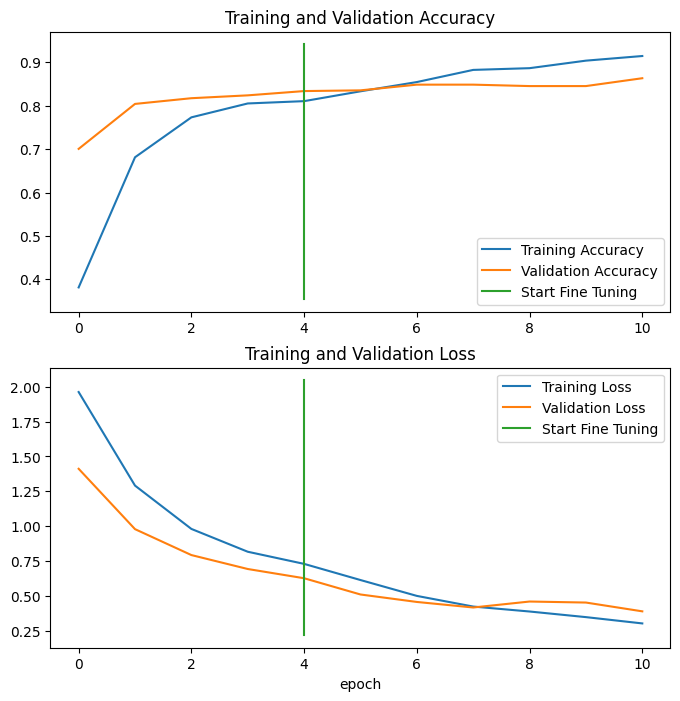

In [77]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

In [81]:
!pip install -U tensorboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 56.3 MB/s eta 0:00:00
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.6
    Uninstalling google-auth-oauthlib-0.4.6:
      Successfully uninstalled google-auth-oauthlib-0.4.6
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.0 requires tensorboard<2.10,>=2.9, but you have tens

# Viewing our experiment data on Tensorboard
🔑**Note:**Anything you upload to TensorBoard.dev is going to be public.So if you have private data,do not upload.

In [ ]:
# View tensorboard logs for transfer learning modelling experiments(should ~4 models)
# upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
 --name "transfer Learning Experiments with 10 Food101 classes"\
 --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning"\
 --one_shot # exits the uploader once its finished uploading

My TensorBoard Experiments are vailable at : https://tensorboard.dev/experiment/j0lMdXo1S0K3pFwkBgnq4g/#scalars&runSelectionState=eyIxMF9wZXJjZW50X2RhdGFfYXVnLzIwMjMwODExLTEzMDgyNi90cmFpbiI6dHJ1ZSwiMTBfcGVyY2VudF9kYXRhX2F1Zy8yMDIzMDgxMS0xMzA4MjYvdmFsaWRhdGlvbiI6dHJ1ZSwiMTBfcGVyY2VudF9mZWF0dXJlX2V4dHJhY3Rpb24vMjAyMzA4MTEtMTMwNjIzL3RyYWluIjp0cnVlLCIxMF9wZXJjZW50X2ZlYXR1cmVfZXh0cmFjdGlvbi8yMDIzMDgxMS0xMzA2MjMvdmFsaWRhdGlvbiI6dHJ1ZSwiMTBfcGVyY2VudF9maW5lX3R1bmVfbGFzdF8xMC8yMDIzMDgxMS0xMzEwMzEvdHJhaW4iOnRydWUsIjEwX3BlcmNlbnRfZmluZV90dW5lX2xhc3RfMTAvMjAyMzA4MTEtMTMxMDMxL3ZhbGlkYXRpb24iOnRydWUsIjEwX3BlcmNlbnRfZmluZV90dW5lX2xhc3RfMTAvMjAyMzA4MTEtMTMxMjM3L3RyYWluIjp0cnVlLCIxMF9wZXJjZW50X2ZpbmVfdHVuZV9sYXN0XzEwLzIwMjMwODExLTEzMTIzNy92YWxpZGF0aW9uIjp0cnVlLCIxX3BlcmNlbnRfZGF0YV9hdWcvMjAyMzA4MTEtMTMwNzM5L3RyYWluIjp0cnVlLCIxX3BlcmNlbnRfZGF0YV9hdWcvMjAyMzA4MTEtMTMwNzM5L3ZhbGlkYXRpb24iOnRydWV9
